In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image


In [2]:
print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")


requests        2.32.3
BeautifulSoup   4.12.3


In [3]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [4]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [5]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [6]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [7]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [8]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [9]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [10]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


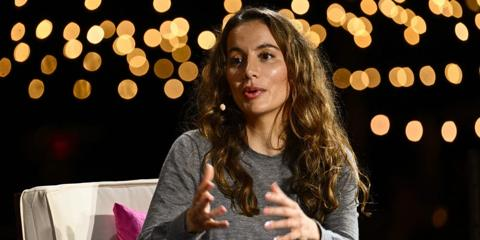

[Mira Murati's new AI startup looking to raise \\$1b at \\$9 billion valuation, sources say](https://www.businessinsider.com/mira-murati-new-startup-thinking-machine-labs-valuation-2025-2) - Business Insider

___

[Disney worker downloaded an AI tool that had malware, gave hackers access to OnePass, led to a huge leak and destroyed career.](https://www.wsj.com/tech/cybersecurity/disney-employee-ai-tool-hacker-cyberattack-3700c931)

___

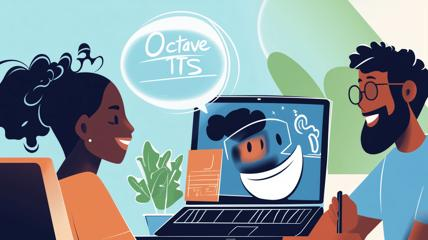

[Hume launches new text-to-speech model Octave that generates custom AI voices with adjustable emotions](https://venturebeat.com/ai/hume-launches-text-to-speech-model-octave/) - VentureBeat

___

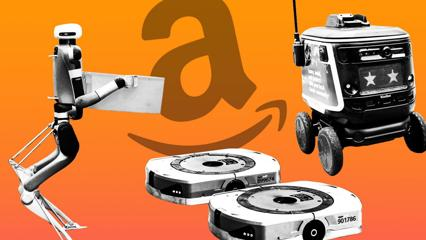

[Amazon spending \\$25b on warehouse automation, which will presumably reduce headcount](https://www.ft.com/content/50b7ecc3-08de-433a-9a5b-6d6590cf8179)

___

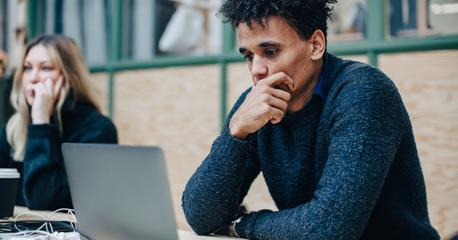

[52% of US workers are more worried than optimistic about AI](https://www.pewresearch.org/social-trends/2025/02/25/u-s-workers-are-more-worried-than-hopeful-about-future-ai-use-in-the-workplace/) - Pew Research Center

___

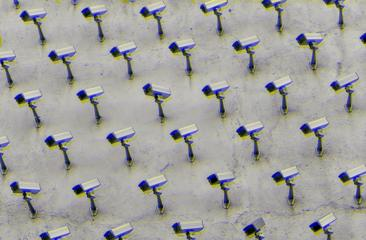

[Video monitoring AI for factory workers sparks backlash. 

To be paired with a humanoid android wielding a whip mayhaps?](https://techcrunch.com/2025/02/25/y-combinator-deletes-posts-after-a-startups-demo-goes-viral/) - TechCrunch

___

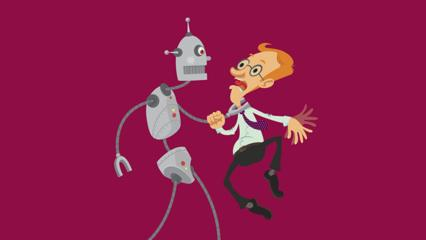

[umm k](https://arstechnica.com/ai/2025/02/groks-uncensored-ai-voice-mode-lets-users-talk-sex-therapy-and-conspiracies/) - Ars Technica

___

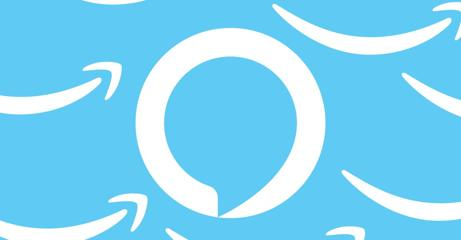

[All the news from today's Amazon Alexa event in New York City.](https://www.theverge.com/news/618262/amazon-alexa-event-2025-ai-echo-products-news) - The Verge

___

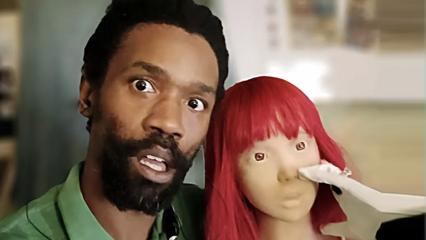

[what did I just read](https://www.the-sun.com/tech/13617969/emotional-support-relationship-ai-robot/) - The US Sun

___

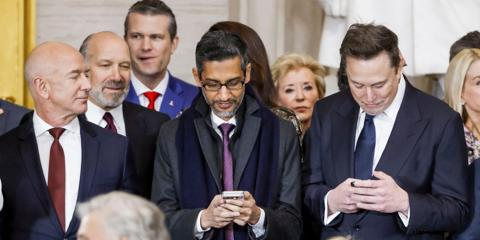

[Aggregators on top of aggregators, all the way down. Some online services won't survive.](https://www.businessinsider.com/ai-agents-internet-dark-google-openai-anthropic-2025-1) - Business Insider

___

[16 Years as a Graphic designer, 8 years as a Photographer, ruined by AI, more than mildly infuriating maybe?](https://www.reddit.com/r/mildlyinfuriating/comments/1iylgwu/16_years_as_a_graphic_designer_8_years_as_a/)

___

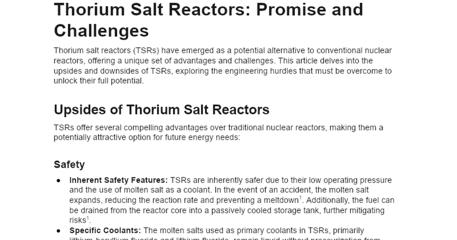

[more detailed than Gemini 1.5 Deep Research which is also pretty good, surfaces the main point I think, haven't overcome challenge of reliably and safely handling highly corrosive salts at high temperature](https://docs.google.com/document/d/1vv5xgANXm9RNm2xnZIJIYR6sLqvvnP54xXTg1IvqX-0/edit?tab=t.0) - Google Docs

___

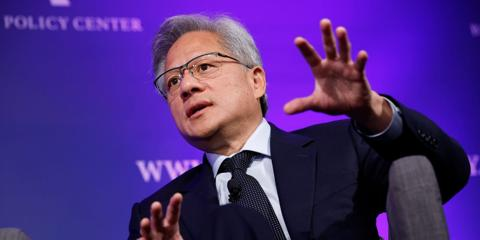

[Nvidia's earnings today have turned into a quarterly AI State of the Union](https://www.businessinsider.com/nvidias-earnings-question-spending-too-much-ai-2025-2) - Business Insider

___

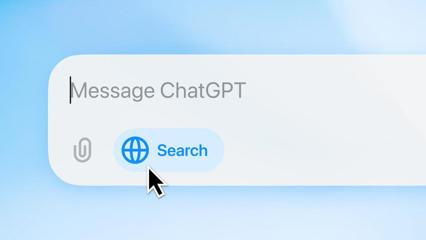

[Nearly all UK undergrads use AI in their studies, according to a new report](https://www.engadget.com/ai/nearly-all-uk-undergrads-use-ai-in-their-studies-according-to-a-new-report-144221715.html) - Engadget

___

[Bridgetown uses AI agents to conduct automated due diligence.](https://www.geekwire.com/2025/bridgetown-a-seattle-startup-that-uses-ai-agents-to-automate-research-tasks-raises-19m/)

___

[American Psychological Associations warns that AI chatbots are violating clinical standards](https://www.nytimes.com/2025/02/24/health/ai-therapists-chatbots.html)

___

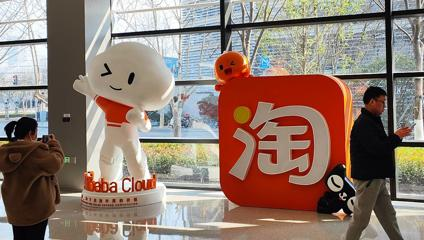

[Alibaba open-sources and offers free access to its AI model that can generate realistic video and images](https://www.engadget.com/ai/alibaba-offers-free-access-to-its-ai-model-that-can-generate-realistic-video-and-images-133045633.html) - Engadget

___

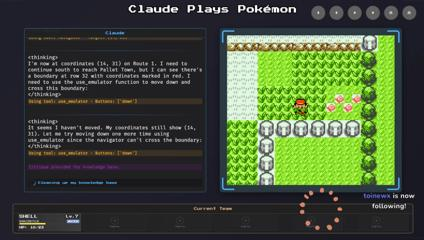

[Anthropic livestreams Claude playing Pokémon](https://techcrunch.com/2025/02/25/anthropics-claude-ai-is-playing-pokemon-on-twitch-slowly/) - TechCrunch

___

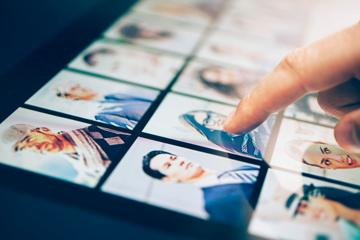

[Agentic AI in recruiting](https://www.forbes.com/councils/forbeshumanresourcescouncil/2025/02/25/are-ai-agents-the-future-of-recruiting/) - Forbes

___

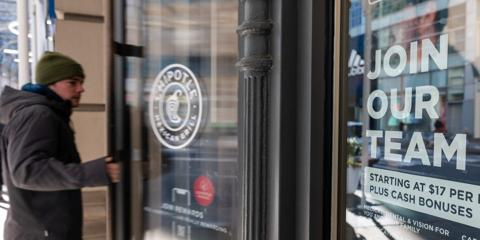

[AI-hiring bots are here. But sometimes they hallucinate.](https://www.businessinsider.com/how-ai-hiring-works-chipotle-burrito-season-application-job-seekers-2025-2) - Business Insider

___

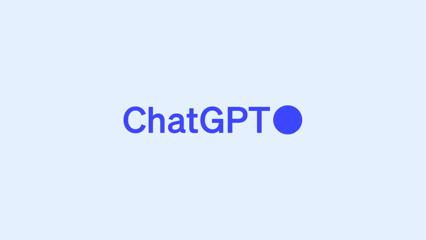

[First attempt at OpenAI Deep Research was impressive I think?](https://chatgpt.com/share/67bea068-02e4-8006-9837-1dd26104623e) - ChatGPT

___

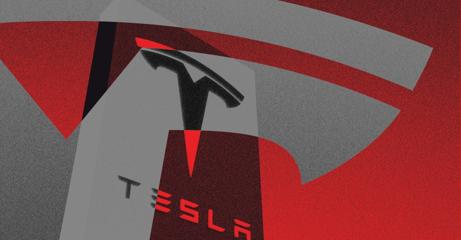

[Tesla reportedly launches FSD in China — or has it?](https://www.theverge.com/news/619092/tesla-fsd-china-update-falls-short) - The Verge

___

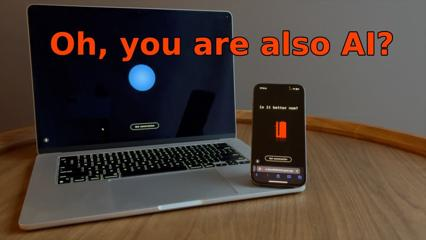

[r2d2 is real, man](https://www.youtube.com/watch?v=EtNagNezo8w) - YouTube

___

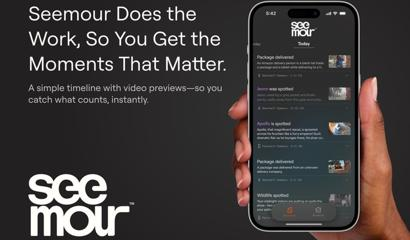

[Prompt AI’s Seemour launches visual intelligence platform for the home

I guess if you want to ask your smart home questions like when was the milkman here and how long did he stay, it has to understand what it sees, but maybe it's creepy surveillance overkill and a double-edged sword.](https://venturebeat.com/games/prompt-ais-seemour-launches-visual-intelligence-platform-for-the-home/) - VentureBeat

___

name 'httplib' is not defined


[Venerable vector database Milvus offers local / private / on premise deep research](https://milvus.io/blog/introduce-deepsearcher-a-local-open-source-deep-research.md)

___

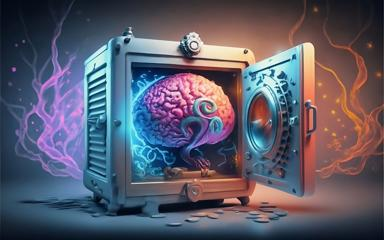

[BNY deploys agents](https://venturebeat.com/ai/how-big-u-s-bank-bny-manages-armies-of-ai-agents/) - VentureBeat

___

[How Factory is turning AI into ‘a junior developer in a box’](https://www.fastcompany.com/91279593/factory-ai-code-generation-matan-grinberg-eno-reyes)

___

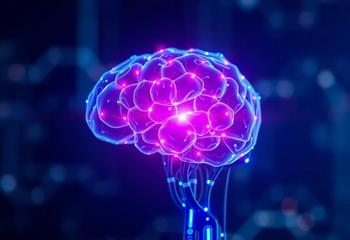

[AI challenges for philosophy. LLMs challenge the idea of innate grammars, they learn language from scratch without parsers or grammars, and are more human-like than programming languages with formal grammars. But humans are far more efficient learners so could have native language circuits](https://hackernoon.com/philosophers-challenge-the-idea-that-ai-lacks-true-understanding)

___

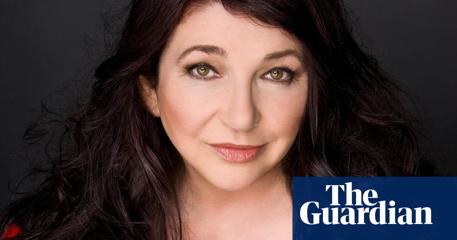

[More on the UK musician protest](https://www.theguardian.com/technology/2025/feb/25/kate-bush-damon-albarn-1000-artists-silent-ai-protest-album-copyright) - the Guardian

___

[Meta Discusses \\$200 Billion AI Data Center Project](https://www.theinformation.com/articles/meta-discusses-200-billion-ai-data-center-project)

___

nice sunset in nyc tonight

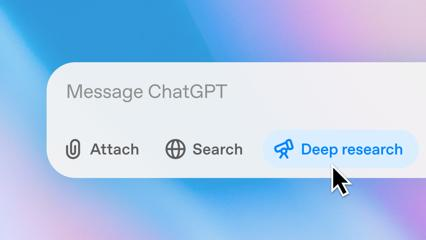

[OpenAI expands Deep Research to all paying ChatGPT users](https://www.engadget.com/ai/openai-expands-deep-research-to-all-paying-chatgpt-users-200045108.html?guccounter=1) - Engadget

___

[iPhone dictation hears 'racist' as 'Trump', Apple working on a fix](https://www.tiktok.com/@user9586420191789/video/7472830639327366446?refer=embed)

___

[DeepSeek said to be rushing a new AI model to market](https://www.reuters.com/technology/artificial-intelligence/deepseek-rushes-launch-new-ai-model-china-goes-all-2025-02-25/)

___

In [ ]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [ ]:
print(datetime.now())

In [ ]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

In [ ]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


In [ ]:
from typing import TypedDict, Annotated

class Point2D(TypedDict, total=False):
    x: int
    y: int
    label: str

a: Point2D = {'x': 1, 'y': 2, }  # 


In [ ]:
a

In [ ]:
b

